In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import h5py
from salishsea_tools import viz_tools
import numpy.ma as ma
%matplotlib inline

import tools

## Need

1. Visualise 2D thickness and surface oil concentration with scopes and quivers
2. Visualise the concentration with quivers
3. Concentration by depth heat map with sea surface height
4. White cap coverage and Sea surface height where we have oil

### 1. Visualise 2D thickness and surface oil concentration with scopes and quivers

In [10]:
# first, develop tools

# we need the bounds for visualisation as well as the max for both quantities for normalisation
# while we are doing this, we should save the arrays in memory for speed

mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02').tmaskutil.isel(time = 0).values[1:897:,1:397]

def plot_params(array, mask_value = 0):
    if len(array.shape) == 3:
        z_indices, y_indices, x_indices = np.where(array != mask_value)
    else: 
        y_indices, x_indices = np.where(array != mask_value)
    if y_indices.shape[0] == 0:
        return False
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()

    if len(array.shape) == 3:
        array = array[...,:,y_min:y_max, x_min:x_max]
    else:
        array = array[y_min:y_max, x_min:x_max]
    maxval = array.max()
    print('aaaa')
    print(array.shape)
    print(array.sum())
    return (array, y_min, y_max, x_min, x_max, maxval)

def surface_conc_params(xarray, mask_values = 0):
    return plot_params(xarray.OilConcentration_3D.isel(grid_z = 39).values)

def thickness_params(xarray, mask_values= 0):
    return plot_params(xarray.Thickness_2D.values)

def make_scope(array):
    if array.sum() != 0:
        array_shape = array.shape
        y_indices, x_indices = np.where(array != 0)
        xs_min, xs_max = x_indices.min(), x_indices.max()
        ys_min, ys_max = y_indices.min(), y_indices.max()
        increase = 5
        if ys_min < increase:
            ys_min = 0
        else:
            ys_min = ys_min - increase

        if ys_max + increase > array_shape[0]:
            ys_max = array_shape[0]
        else:
            ys_max = ys_max + increase

        if xs_min < increase:
            xs_min = 0
        else:
            xs_min = xs_min - increase

        if xs_max + increase > array_shape[1]:
            xs_max = array_shape[1]
        else:
            xs_max = xs_max + increase
        print(array)
        scope = array[ys_min:ys_max, xs_min:xs_max]
        print(scope)
        return (scope, ys_min, ys_max, xs_min, xs_max)
    else:
        scope = False

def current_quivers(file, i, ymin, ymax, xmin, xmax):
    """ produce the required arrays for producing current quivers over the oil spill region 
    """
    i = i + 1
    attr = (5 - len(str(i))) * "0" + str(i)
    current_u = file['Results']['velocity U'][f'velocity U_{attr}'][39][xmin:xmax, ymin:ymax]
    current_v = file['Results']['velocity V'][f'velocity V_{attr}'][39][xmin:xmax, ymin:ymax]
    return current_u.T, current_v.T

def produce_mask(yshape, xshape):
    mask = np.ones([yshape,xshape])
    interval = 5
    for i in range(int(yshape/interval)):
        for j in range(int(xshape/interval)):
            mask[i*interval][j*interval] = 0

In [24]:
def plot_thick_conc(xr_path, currents_path, winds_path, outfile_path, mask = mask):
    # load the netcdf file
    xarray = xr.open_dataset(xr_path)
    # get the plotting parameters for 2D oil thickness
    thickness_param = thickness_params(xarray)
    if thickness_param is False:
        print('NO OIL WAS SPILT')
        return
    else:
        t_array, t_y_min, t_y_max, t_x_min, t_x_max, t_maxval = thickness_param
    
    # get the plotting parameters for suface concentration
    surface_conc_param = surface_conc_params(xarray)
    if surface_conc_param is False:
        print('NO SURFACE OIL CONCENTRATION FOUND')
        return
    else:
        c_array, c_y_min, c_y_max, c_x_min, c_x_max, c_maxval = surface_conc_param
    
    time_values = xarray.time.values
    
    # land masks
    t_mask = mask[t_y_min: t_y_max, t_x_min: t_x_max] # mask for oil thickness
    c_mask = mask[c_y_min: c_y_max, c_x_min: c_x_max] # mask for oil surface concentration
    
    currents = h5py.File(currents_path)
    winds = h5py.File(winds_path)
    
    t_q_mask = produce_mask(t_y_max-t_y_min, t_x_max-t_x_min)
    c_q_mask = produce_mask(c_y_max-c_y_min, c_x_max-c_x_min)
    def update_frame(t, 
                     t_array = t_array, t_y_min = t_y_min, t_y_max = t_y_max, t_x_min = t_x_min, t_x_max = t_x_max, t_maxval = t_maxval,
                     c_array = c_array, c_y_min = c_y_min, c_y_max = c_y_max, c_x_min = c_x_min, c_x_max = c_x_max, c_maxval = c_maxval,
                     times = time_values, t_mask = t_mask, c_mask = c_mask, t_q_mask = t_q_mask, c_q_mask = c_q_mask,
                     current = currents, winds = winds
                    ):
        # set up the subplot layout
        grid = plt.GridSpec(2,3)
        # !----------------------------------------------------------------------------------------------------------------------------
        # plot the surface oil thickness
        ax = plt.subplot(grid[0:,0])
        thickness = t_array[t]
        # get whatever should be in the scope
        scope_result = make_scope(thickness)
        if scope_result is (False or None):
            scope = False
        else:
            scope, ys_min, ys_max, xs_min, xs_max = scope_result
        
        # for the horizontal markers on the colorbar
        thickmin, thickmax = thickness.min(), thickness.max()
        print(thickness.sum())
        # mask out the zeros
        condlist = [thickness == 0, thickness != 0]
        choicelist = [np.nan, thickness]
        thickness = np.select(condlist, choicelist)
        
        # plot full region normalised to log scale
        plt.pcolormesh(thickness, 
                       animated = True,
                       norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                       vmin = 0.0001,
                       vmax = t_maxval,
                       cmap = 'inferno')
        
        # plot the scope boundaries
        if scope is not False:
            plt.hlines(ys_max, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.hlines(ys_min, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.vlines(xs_max, ymin = ys_min, ymax = ys_max, colors = 'Green')
            plt.vlines(xs_min, ymin = ys_min, ymax = ys_max, colors = 'Green')
        
        # plot colorbar normalised to log scale, with current min and max thicknesses
        cbar = plt.colorbar(plt.pcolormesh(np.meshgrid(np.array([0.0001, t_maxval])),
                                           norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                                           cmap = 'inferno'))
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel('Oil thickness (microns)', rotation=270)
        cbar.ax.hlines(thickmax, xmin =  0, xmax = 150, colors = 'Red')
        cbar.ax.hlines(thickmin, xmin =  0, xmax = 150, colors = 'Blue')
        # plot the land mask and coastline
        plt.contourf(t_mask, levels = [-0.1, 0.1], colors = 'Burlywood')
        plt.contour(t_mask, levels = [-0.1, 0.1], colors = 'k')        
        # thickness limits readouts
        plt.title(f'max thickness {thickmax}\nmin thickness {thickmin}')
        # plot current quivers
        U, V = current_quivers(current, t, t_y_min, t_y_max, t_x_min, t_x_max)
        # mask out everything but every nth quiver
        U_ma, V_ma = ma.array(U, mask = t_q_mask), ma.array(V, mask = t_q_mask)
        currentq = plt.quiver(U_ma, V_ma, scale = 20, width = 0.003)
        
        u, v = wind_quivers(wind, t, t_y_min, t_y_max, t_x_min, t_x_max)
        u,v = np.average(u), np.average(v)
        windq = plt.quiver(10, t_y_max - t_y_min - 10, u, v, color = 'Red')
        plt.quiverkey(windq, 1.4,0.98, 5, label = 'Wind (1 m/s)', transform=ax.transAxes)
        
        viz_tools.set_aspect(ax)
        
        # !-----------------------------------------------------------------------------------------------------------------------------
        # plot the 2D thickness scope
        ax = plt.subplot(grid[0, 2])
        if scope is False:
            plt.cla()
            plt.xticks([])
            plt.yticks([])
        else:
            # mask out the scope contants, plot land mask and coastline
            condlist = [scope == 0, scope != 0]
            choicelist = [np.nan, scope]
            plt.pcolormesh(np.select(condlist, choicelist),
                           animated = True,
                           norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                           vmin = 0.0001,
                           vmax = t_maxval,
                           cmap = 'inferno')
            scope_mask = t_mask[ys_min:ys_max, xs_min:xs_max]
            plt.contourf(scope_mask,
                         levels = [-0.1, 0.1],
                         colors = 'Burlywood')
            plt.contour(scope_mask,
                        levels = [-0.1, 0.1],
                        colors = 'k')
            # plot the quivers
            U, V = U_ma[ys_min:ys_max, xs_min:xs_max],V_ma[ys_min:ys_max, xs_min:xs_max]
            plt.quiver(U,V , scale = 20 ,width = 0.003, headwidth = 3)
            
            # remove axis ticks
            plt.xticks([])
            plt.yticks([])
        
        # !----------------------------------------------------------------------------------------------------------------------------
        ax = plt.subplot(grid[0:,1])
        concentration = c_array[t]
        # get whatever should be in the scope
        scope_result = make_scope(concentration)
        if scope_result is (False or None):
            scope = False
        else:
            scope, ys_min, ys_max, xs_min, xs_max = scope_result  
        
        # for the horizontal markers on the colorbar
        concmin, concmax = concentration.min(), concentration.max()
        
        # mask out the zeros
        condlist = [concentration == 0, concentration != 0]
        choicelist = [np.nan, concentration]
        concentration = np.select(condlist, choicelist)

        # plot full region normalised to log scale
        plt.pcolormesh(concentration, 
                       animated = True,
                       norm=colors.LogNorm(vmin=0.0001, vmax=c_maxval),
                       vmin = 0.0001,
                       vmax = c_maxval,
                       cmap = 'inferno')
        # plot the scope boundaries
        if scope is not False:
            plt.hlines(ys_max, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.hlines(ys_min, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.vlines(xs_max, ymin = ys_min, ymax = ys_max, colors = 'Green')
            plt.vlines(xs_min, ymin = ys_min, ymax = ys_max, colors = 'Green')
            
        # plot colorbar normalised to log scale, with current min and max concentrations
        cbar = plt.colorbar(plt.pcolormesh(np.meshgrid(np.array([0.0001, c_maxval])),
                                           norm=colors.LogNorm(vmin=0.0001, vmax=c_maxval),
                                           cmap = 'inferno'))
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel('Oil concentration (ppm)', rotation=270)
        cbar.ax.hlines(concmax, xmin =  0, xmax = 300, colors = 'Red')
        cbar.ax.hlines(concmin, xmin =  0, xmax = 300, colors = 'Blue')
        # plot the land mask and coastline
        plt.contourf(c_mask, levels = [-0.1, 0.1], colors = 'Burlywood')
        plt.contour(c_mask, levels = [-0.1, 0.1], colors = 'k')        
        # thickness limits readouts
        plt.title(f'max concentration {concmax}\nmin concentration {concmin}')
        # plot current quivers
        U, V = current_quivers(current, t, c_y_min, c_y_max, c_x_min, c_x_max)
        # mask out everything but every nth quiver
        U_ma, V_ma = ma.array(U, mask = c_q_mask), ma.array(V, mask = c_q_mask)
        currentq = plt.quiver(U_ma, V_ma, scale = 20, width = 0.003)
        
        u, v = wind_quivers(wind, t, c_y_min, c_y_max, c_x_min, c_x_max)
        u,v = np.average(u), np.average(v)
        windq = plt.quiver(10, c_y_max - c_y_min - 10, u, v, color = 'Red')
        plt.quiverkey(windq, 1.4,0.98, 5, label = 'Wind (1 m/s)', transform=ax.transAxes)
        
        viz_tools.set_aspect(ax)        
        
        # !------------------------------------------------------------------------------------------------------------------------------
        ax = plt.subplot(grid[1,2])
        if scope is False:
            plt.cla()
            plt.xticks([])
            plt.yticks([])
        else:
            # mask out the scope contants, plot land mask and coastline
            condlist = [scope == 0, scope != 0]
            choicelist = [np.nan, scope]
            plt.pcolormesh(np.select(condlist, choicelist),
                           animated = True,
                           norm=colors.LogNorm(vmin=0.0001, vmax=c_maxval),
                           vmin = 0.0001,
                           vmax = c_maxval,
                           cmap = 'inferno')
            scope_mask = c_mask[ys_min:ys_max, xs_min:xs_max]
            plt.contourf(scope_mask,
                         levels = [-0.1, 0.1],
                         colors = 'Burlywood')
            plt.contour(scope_mask,
                        levels = [-0.1, 0.1],
                        colors = 'k')
            # plot the quivers
            U, V = U_ma[ys_min:ys_max, xs_min:xs_max],V_ma[ys_min:ys_max, xs_min:xs_max]
            plt.quiver(U,V , scale = 20 ,width = 0.003, headwidth = 3)
            
            # remove axis ticks
            plt.xticks([])
            plt.yticks([])
            
        #plt.tight_layout()
        plt.suptitle(times[t])
        print(t)
        # !----------------------------------------------------------------------------------------------------------------------------
    fig = plt.figure(figsize = (16,9))
    ani = animation.FuncAnimation(plt.gcf(), update_frame, range(130, time_values.shape[0]))
    ani.save(outfile_path, writer = animation.FFMpegWriter(), dpi = 100)

aaaa
(162, 45, 54)
37358.8997
aaaa
(162, 45, 55)
72690.3057
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.

NameError: name 'wind_quivers' is not defined

/home/abhudia/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


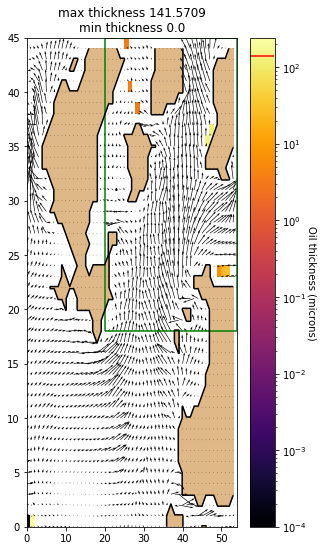

In [25]:
plot_thick_conc('/home/abhudia/viz_test/oil.nc',
                '/home/abhudia/viz_test/curr.hdf5',
                '/home/abhudia/viz_test/winds.hdf5',
                '/home/abhudia/viz_test/test.mp4')

Text(0.5, 1.0, '4')

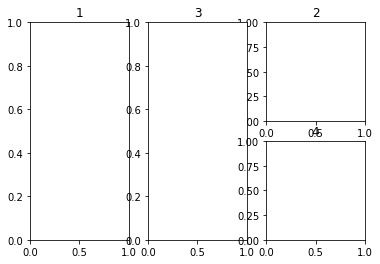

In [40]:
grid = plt.GridSpec(2,3)
ax = plt.subplot(grid[0:,0])
plt.title('1')
ax = plt.subplot(grid[0, 2])
plt.title('2')
ax = plt.subplot(grid[0:,1])
plt.title('3')
ax = plt.subplot(grid[1,2])
plt.title('4')

In [6]:
# load the netcdf file
xarray = xr.open_dataset('/home/abhudia/viz_test/oil.nc')
# get the plotting parameters for 2D oil thickness
thickness_param = thickness_params(xarray)
if thickness_param is False:
    print('NO OIL WAS SPILT')
else:
    t_array, t_y_min, t_y_max, t_x_min, t_x_max, t_maxval = thickness_param

aaaa
(162, 45, 54)
37358.8997
